<a href="https://colab.research.google.com/github/torontodeveloper/Uft-Machine-Learning-Assignments/blob/main/W6_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment for Module 6

In this assignment you will continue working with the housing price per district from the previous module assignment, this time training SVM models, both for regression and classification.

#### Getting the data for the assignment (similar to the notebook from chapter 2 of Hands-On...)

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()

### Fix the categories in the categorical variable

In [5]:
d = {'<1H OCEAN':'LESS_1H_OCEAN', 'INLAND':'INLAND', 'ISLAND':'ISLAND', 'NEAR BAY':'NEAR_BAY', 'NEAR OCEAN':'NEAR_OCEAN'}
housing['ocean_proximity'] = housing['ocean_proximity'].map(lambda s: d[s])

### Add 2 more features

In [6]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["population_per_household"]=housing["population"]/housing["households"]

### Fix missing data

In [7]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

### Create dummy variables based on the categorical variable

In [8]:
one_hot = pd.get_dummies(housing['ocean_proximity'])
housing = housing.drop('ocean_proximity', axis=1)
housing = housing.join(one_hot)

### Check the data

In [9]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 20640 non-null  float64
 1   latitude                  20640 non-null  float64
 2   housing_median_age        20640 non-null  float64
 3   total_rooms               20640 non-null  float64
 4   total_bedrooms            20640 non-null  float64
 5   population                20640 non-null  float64
 6   households                20640 non-null  float64
 7   median_income             20640 non-null  float64
 8   median_house_value        20640 non-null  float64
 9   rooms_per_household       20640 non-null  float64
 10  population_per_household  20640 non-null  float64
 11  INLAND                    20640 non-null  uint8  
 12  ISLAND                    20640 non-null  uint8  
 13  LESS_1H_OCEAN             20640 non-null  uint8  
 14  NEAR_B

### Partition into train and test

Use train_test_split from sklearn.model_selection to partition the dataset into 70% for training and 30% for testing.

You can use the 70% for training set as both training and validation by using cross-validation.


In [10]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.3, random_state=42)

### Features

In [11]:
target = 'median_house_value'
features = list(train_set.columns)
features = [f for f in features if f!=target]

In [12]:
X_train = train_set[features]
y_train = train_set[[target]]

X_test = test_set[features]
y_test = test_set[[target]]

### Scaling features

Similarly, use StandardScaler from sklearn.preprocessing to normalize the training and testing data, using the training data

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Comparing models

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())

### Linear regression on original features (no transformations) --- benchmark

In [15]:
from sklearn.linear_model import LinearRegression
lin_scores = cross_val_score(LinearRegression(), train_set[features], train_set[target], scoring="neg_mean_squared_error", cv=4)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [70142.55721218 67456.39127204 67318.3258893  70866.26065275]
Mean: 68945.88375656855


### 1. Support Vector Machines for Regression

#### (a) In this exercise your goal is to tune SVR with FBR kernel, and make the average score mean_squared_error over 3-folds (cv=3) below 58000.

You are encouraged to try optimizing any of the hyper-parameters of SVR

See http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html for more details

However, as a hint, you can focus on C and gamma.

Hint 2: if when you try different values for a hyper-parameter, the optimal models corresponds to one of the extreme values in your range, that probably means you can keep improving your solution by considering values beyond the current range.



In [16]:
from sklearn.svm import SVR

C_vals = [0.1,1.0,10,100] ## YOUR VALUES FOR C ##
gamma_vals = [0.01,0.1,1,10] ## YOUR VALUES FOR gamma ##

param_grid = [{'C':C_vals, 'gamma':gamma_vals}]
grid_search_rbf = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=3,scoring='neg_mean_squared_error')
grid_search_rbf.fit(X_train, np.ravel(y_train))

GridSearchCV(cv=3, estimator=SVR(),
             param_grid=[{'C': [0.1, 1.0, 10, 100],
                          'gamma': [0.01, 0.1, 1, 10]}],
             scoring='neg_mean_squared_error')

In [17]:
print(grid_search_rbf.best_params_)
print(np.sqrt(-grid_search_rbf.best_score_))

{'C': 100, 'gamma': 0.1}
102768.55985356086


### Performance on Test Set

In [18]:
from sklearn.metrics import mean_squared_error

final_model = grid_search_rbf.best_estimator_   ## THIS SHOULD BE THE BEST GRID_SEARCH ##

y_te_estimation = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, y_te_estimation)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

97296.62771002138


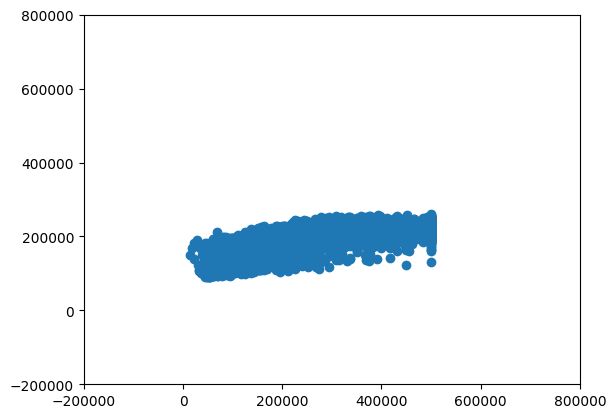

In [19]:
import matplotlib.pyplot as plt

plt.scatter(x=y_test, y=y_te_estimation)
plt.xlim([-200000,800000])
plt.ylim([-200000,800000])
plt.show()

### 2. SVM for Classification

Now we transform the continuous target into a binary variable, indicating whether or not the price is above the average $179700


In [20]:
from sklearn.metrics import accuracy_score

In [21]:
np.median(housing[['median_house_value']])

179700.0

#### Binary target variable

In [22]:
y_tr_b = 1*np.ravel(y_train>=179700.0)
y_te_b = 1*np.ravel(y_test>=179700.0)

#### Linear SVM for classification

In [23]:
from sklearn.svm import LinearSVC

In [24]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_tr_b)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=42)

In [25]:
y_pred = lin_clf.predict(X_test)
accuracy_score(y_te_b, y_pred)

0.8393087855297158

### (a) Does SVC (with default hyper-parameters) improve the performance of the linear SVM?

In [27]:
from sklearn.svm import SVC

In [28]:
## YOUR CODE HERE ##
## YOUR CODE HERE ##
## YOUR CODE HERE ##
## YOUR CODE HERE ##
lin_clf = SVC(random_state=42)
lin_clf.fit(X_train, y_tr_b)

SVC(random_state=42)

In [29]:
y_pred = lin_clf.predict(X_train)
accuracy_score(y_tr_b, y_pred)

0.866140642303433

### (b) Use randomized search to tune hyper-parameters of SVC and improve its performance

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

In [ ]:
## YOUR CODE HERE ##
## YOUR CODE HERE ##
## YOUR CODE HERE ##
## YOUR CODE HERE ##
## YOUR CODE HERE ##
## YOUR CODE HERE ##
svc = SVC()
param_dist = {
    'C':reciprocal(1e-3,1e3),
    'kernel':['rbf'],
    'degree':[2],
    'gamma':[0.01,0.1,1],
    'coef0':uniform(0,10)
}
random_search = RandomizedSearchCV(svc,param_distributions=param_dist,random_state=42)
random_search.fit(X_train,y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/pytho